## read in data

In [1]:
import pandas as pd
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np

# params
prop = 'change'
tgt = 'soc_change'
version = '20250301'
space = 'normal'

covs = pd.read_csv(f'./metric/feature_selected_{prop}_v{version}.txt', header=None)[0].tolist() 
model = joblib.load(f'./model/model_rf.{prop}_ccc_v{version}.joblib')
model.n_jobs = 90

train = pd.read_parquet(f'./material/data.pair_train_v{version}.pq')
train = train.dropna(subset=covs+[tgt],how='any')
test = pd.read_parquet(f'./material/data.pair_test_v{version}.pq')
test = test.dropna(subset=covs+[tgt],how='any')

# train = train.loc[train['soc']<50]
# test = test.loc[test['soc']<50]

## train the model

In [2]:
# train the model
from trees_rf import cast_tree_rf
ttprint(f'start training')
model.fit(train[covs], train[tgt])
ttprint(f'finish training')
model = cast_tree_rf(model)

# variable importance
importance_df = pd.DataFrame({'feature': covs, 'importance': model.feature_importances_})
importance_df = importance_df.sort_values(by='importance', ascending=False)
importance_df.to_csv(f'./metric/feature_importance.{prop}_{version}.csv', index=False)


[15:01:41] start training
[15:01:41] finish training


## generate prediction

In [3]:
# tree predictions
tree_predictions = model.predict(test[covs])

# get point prediction
y_pred = np.mean(tree_predictions, axis=0)
# y_pred = np.expm1(y_pred)
test[f'pred'] = y_pred

# uncertainty in std
# tree_predictions = np.expm1(tree_predictions)
test['pred_std'] = np.std(tree_predictions, axis=0)


## evaluate prediction accuracy

/tmp/ipykernel_82470/2183539345.py:66: RuntimeWarning: invalid value encountered in log1p
  ax2.plot(np.log1p(show_range), np.log1p(show_range), "-k", alpha=0.5)


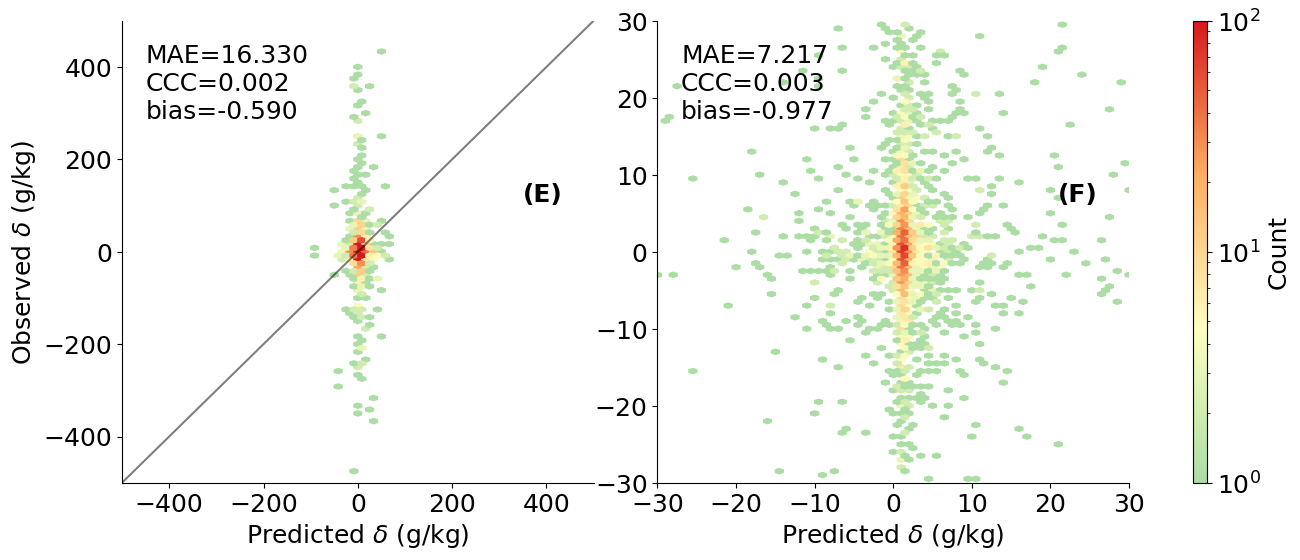

In [7]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from model_fit import calc_metrics
import math
import matplotlib.pyplot as plt
from model_fit import calc_metrics

cet_l19_cmap = LinearSegmentedColormap.from_list(
    "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
)
vmax = 100
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.03], wspace=0.2)

# Subplot 1
show_range = [-500, 500]
ax1 = fig.add_subplot(gs[0])
y_t = test['soc_change']
y_p = test['pred']
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_p, y_t, 'normal')
hb1 = ax1.hexbin(y_p, y_t, gridsize=(60, 60), cmap=cet_l19_cmap,
                 extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
                 mincnt=1, vmax=vmax, bins='log')
ax1.set_xlabel('Predicted $\delta$ (g/kg)')
ax1.set_ylabel('Observed $\delta$ (g/kg)')
ax1.text(0.05, 0.95, 
         f'MAE={mae:.3f}\nCCC={ccc:.3f}\nbias={bias:.3f}', 
         transform=ax1.transAxes,
         verticalalignment='top',
         fontsize=18)
ax1.text(0.85, 0.65, 
         f'(E)', 
         transform=ax1.transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')
ax1.plot(show_range, show_range, "-k", alpha=0.5)
ax1.set_xlim(show_range)
ax1.set_ylim(show_range)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Subplot 2
show_range = [-30, 30]
ax2 = fig.add_subplot(gs[1])
y_t = test.loc[test['soc_change'].abs() < 30, 'soc_change']
y_p = test.loc[test['soc_change'].abs() < 30, 'pred']
rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_p, y_t, 'normal')
hb2 = ax2.hexbin(y_p, y_t, gridsize=(60, 60), cmap=cet_l19_cmap,
                 extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
                 mincnt=1, vmax=vmax, bins='log')
ax2.set_xlabel('Predicted $\delta$ (g/kg)')
ax2.set_ylabel(' ')
ax2.text(0.05, 0.95, 
         f'MAE={mae:.3f}\nCCC={ccc:.3f}\nbias={bias:.3f}', 
         transform=ax2.transAxes,
         verticalalignment='top',
         fontsize=18)
ax2.text(0.85, 0.65, 
         f'(F)', 
         transform=ax2.transAxes,
         verticalalignment='top',
         fontsize=18,
         fontweight='bold')
ax2.plot(np.log1p(show_range), np.log1p(show_range), "-k", alpha=0.5)
ax2.set_xlim(show_range)
ax2.set_ylim(show_range)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Colorbar
cbar_ax = fig.add_subplot(gs[2])
cb = fig.colorbar(hb2, cax=cbar_ax)
cb.set_label('Count')

plt.savefig(f'./figure/plot_mdl.pair_evaluation.{prop}_pred.svg', bbox_inches='tight')
plt.show()


## PI estimation evaluation

In [6]:
# calculate quantile predictions
quantiles = [0.005, 0.025, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
             0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.975, 0.995]
y_q = np.percentile(tree_predictions, [q * 100 for q in quantiles], axis=0)

# PIW 90% for test
test['piw_90'] = y_q[-3,:]-y_q[2,:]

# calculate QCP
def calc_qcp(predictions, true_values, quantile):
    return np.mean(true_values <= predictions)

qcp = []
for ii in range(len(quantiles)):
    qcp.append(calc_qcp(y_q[ii,:], test[tgt], quantiles[ii]))

In [7]:
# calculate PICP, PIW
def calc_picp(lower_bounds, upper_bounds, true_values):
    within_bounds = np.sum((true_values >= lower_bounds) & (true_values <= upper_bounds))
    picp = within_bounds / len(true_values)
    return picp

pi = []
picp = []
piw_m = []
piw_med = []
for ii in range(12):
    jj = len(quantiles)-1-ii
    pi.append(round(1-quantiles[ii]*2,2))
    picp.append(calc_picp(y_q[ii,:], y_q[jj,:], test[tgt]))
    piw_m.append(np.mean(y_q[jj,:]-y_q[ii,:]))
    piw_med.append(np.median(y_q[jj,:]-y_q[ii,:]))

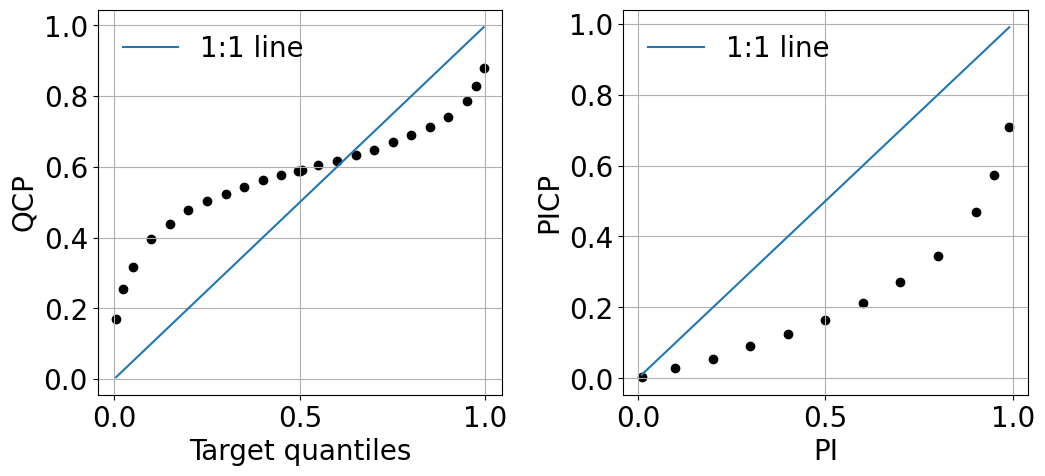

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot 1: Target quantiles vs. realized quantiles
axs[0].plot(quantiles, quantiles, label='1:1 line')
axs[0].scatter(quantiles, qcp, color='black')
axs[0].set_xlabel('Target quantiles', fontsize=20)
axs[0].set_ylabel('QCP', fontsize=20)
axs[0].grid(True)
axs[0].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[0].tick_params(axis='both', which='major', labelsize=20)

# Plot 2: PI vs. PICP
# ymin, ymax = axs[1].get_ylim()
# axs[1].plot([0.95, 0.95], [0,1], 
#             color='orange', linestyle='--', linewidth=2, label='Target PI 95%:\nPICP 93%')
# axs[1].axvline(x=0.95, color='orange', linestyle='--', linewidth=2)  #Use axvline to draw a vertical line across the entire plot, , label=Target PI 95%:\nPICP {picp[1]*100:.0f}
axs[1].plot(pi, pi, label='1:1 line')
axs[1].scatter(pi, picp, color='black')
axs[1].set_xlabel('PI', fontsize=20)
axs[1].set_ylabel('PICP', fontsize=20)
# axs[1].text(0.26, 0.16, f'PI 95% - PICP 93%', #\n{picp[1]:.2f}
#             ha='left', va='top', transform=axs[1].transAxes, fontsize=20)  # Adjusted text position
axs[1].grid(True)
axs[1].legend(fontsize=20, frameon=False)  # Make legend background transparent
axs[1].tick_params(axis='both', which='major', labelsize=20)

# Adjust layout to prevent overlapping and add space between the panels
plt.subplots_adjust(wspace=0.3)  # Increase the space between the two plots
plt.savefig(f'./figure/plot_mdl.pair_evaluation.{prop}_uncertainty.svg', bbox_inches='tight')

plt.show()

## correction factor
- we could clearly see under-estimation of PIW

In [9]:
# read in delta modelled by delta model
pair = pd.read_parquet(f'./metric/pair_predicted_v{version}.pq')
pair = pair[['id', 'pred_pair', 'pred_std_pair', 'pred_change', 'noise', 'snr']]
pair = pair.rename(columns={'pred_change':'pred_change_pntmdl', 'noise':'noise_pntmdl', 'snr':'snr_pntmdl'})

# merge delta predicted by delta model and carbon model
test = test.merge(pair, how='left', on='id')

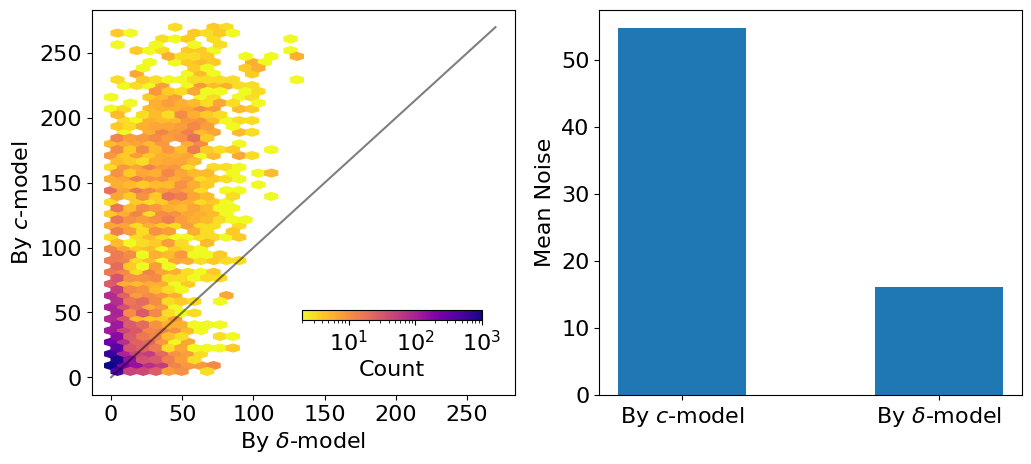

In [89]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: Hexbin ---
ax = axes[0]
show_range = [0, 270]
hb = ax.hexbin(
    test['pred_std'], test['noise_pntmdl'],
    gridsize=(30, 30),
    extent=[show_range[0], show_range[1], show_range[0], show_range[1]],
    cmap='plasma_r', mincnt=2, vmax=1000, bins='log'
)
ax.set_xlabel('By $\delta$-model')
ax.set_ylabel('By $c$-model')
ax.plot(show_range, show_range, "-k", alpha=0.5)

# Add colorbar for hexbin
cbar_ax = fig.add_axes([0.3, 0.26, 0.15, 0.02])  # [left, bottom, width, height]
cb = fig.colorbar(hb, cax=cbar_ax, orientation='horizontal')
cb.set_label('Count')

# --- Plot 2: Bar plot ---
ax = axes[1]
ax.bar(['By $c$-model', 'By $\delta$-model'], [test['noise_pntmdl'].mean(), test['pred_std'].mean()], width=0.5)
ax.set_ylabel('Mean Noise')
plt.savefig(f'./figure/plot_mdl.compare_noise.{prop}.svg', bbox_inches='tight')
plt.show()


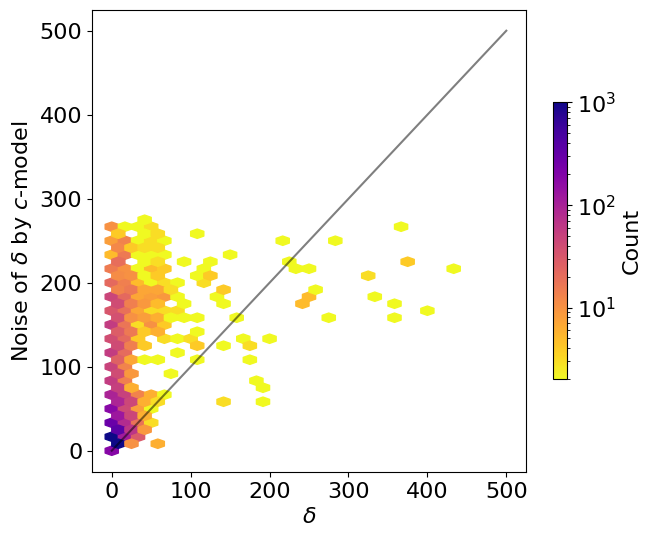

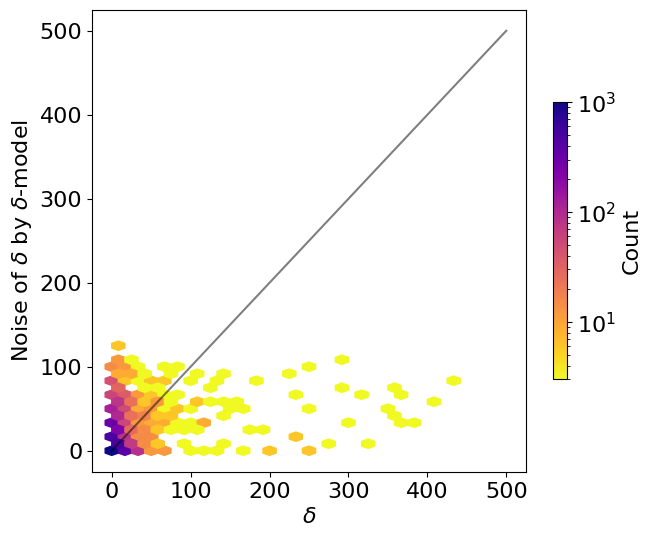

In [88]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(7, 6))

show_range = [0,500]
hb = ax.hexbin(test['soc_change'], test['noise_pntmdl'], gridsize=(30, 30), extent=[show_range[0],show_range[1],show_range[0],show_range[1]], cmap='plasma_r', mincnt=2, vmax=1000, bins='log') #,, vmax=vmax
ax.set_xlabel(f'$\delta$')
ax.set_ylabel(f'Noise of $\delta$ by $c$-model')
ax.plot(show_range, show_range, "-k", alpha=.5)
cb = fig.colorbar(hb, shrink=0.6)
cb.set_label('Count')
plt.show()


fig, ax = plt.subplots(figsize=(7, 6))
hb = ax.hexbin(test['soc_change'], test['pred_std'], gridsize=(30, 30), extent=[show_range[0],show_range[1],show_range[0],show_range[1]], cmap='plasma_r', mincnt=2, vmax=1000, bins='log') #,, vmax=vmax
ax.set_xlabel(f'$\delta$')
ax.set_ylabel(f'Noise of $\delta$ by $\delta$-model')
ax.plot(show_range, show_range, "-k", alpha=.5)
cb = fig.colorbar(hb, shrink=0.6)
cb.set_label('Count')
plt.show()

In [5]:
# from matplotlib.colors import LinearSegmentedColormap
# from model_fit import calc_metrics
# import math
# import numpy as np
# import matplotlib.pyplot as plt

# cet_l19_cmap = LinearSegmentedColormap.from_list(
#     "CET-L19", ["#abdda4", "#ffffbf", "#fdae61", "#d7191c"]
# )

# # y_pred = test[f'{tgt}_test']
# # y_test = test['soc_log1p']
# # rmse, mae, medae, mape, ccc, r2, bias = calc_metrics(y_pred, y_test, 'log1p')
    
# # show_range = [
# #     math.floor(np.min([y_test.min(), y_pred.min()])),
# #     math.ceil(np.max([y_test.max(), y_pred.max()]))]
# show_range = [-300,300]
# vmax = 0.05 * len(y_test)

# plt.rcParams.update({'font.size': 16})
# fig, ax = plt.subplots(figsize=(8, 7))

# # ax.set_title(f'$\delta$ model\nMAE={mae:.2f}\nCCC={ccc:.2f}\nbias={bias:.2f}') # ({ccc_log:.2f})

# # Use the CET-L19 colorblind-friendly colormap
# hb = ax.hexbin(y_pred, y_test, gridsize=(40, 40), cmap=cet_l19_cmap, extent=[show_range[0],show_range[1],show_range[0],show_range[1]], mincnt=2, vmax=vmax) #, bins='log'
# ax.set_xlabel(f'Predicted $\delta$ (g/kg)')
# ax.set_ylabel(f'Observed $\delta$ (g/kg)')
# ax.set_aspect('auto', adjustable='box')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.set_xlim(show_range)
# ax.set_ylim(show_range)
# ax.plot(show_range, show_range, "-k", alpha=.5)

# ax.text(0.05, 0.95, 
#         f'$\delta$ model\nMAE={mae:.2f}\nCCC={ccc:.2f}\nbias={bias:.2f}', 
#         transform=ax.transAxes,
#         verticalalignment='top',
#         fontsize=16)


# # Create a colorbar with proper spacing
# cax = fig.add_axes([ax.get_position().x1 + 0.05, ax.get_position().y0, 0.02, ax.get_position().height])
# cb = fig.colorbar(hb, cax=cax)
# cb.set_label('Count')

# plt.tight_layout(rect=[0, 0, 0.92, 1])  # Adjust the right margin to make room for colorbar
# plt.show()

NameError: name 'y_test' is not defined